# Video analysis

## Panorama

Let's play around with making a panorama from a video clip

In [1]:
import cv2 as cv
import numpy as np
import sys
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# RESIZED RESOLUTION
res_w = 640
res_h = 360

# PROJECTION CANVAS
proj_w = 3000
proj_h = 1300
off_x = 200
off_y = 150

In [3]:
def blendImages(sourceTransform, referenceTransform):
    '''
    Naive blending for frame stitching
    Input:
        - sourceTransform: source frame projected onto reference frame plane
        - referenceTransform: reference frame projected onto same space

    Output:
        - blendedOutput: naive blending result from frame stitching
    '''

    blendedOutput = referenceTransform
    indices = referenceTransform == 0
    blendedOutput[indices] = sourceTransform[indices]

    return (blendedOutput / blendedOutput.max() * 255).astype(np.uint8)

In [4]:
def compute_homography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    n = 4
    e = 0
    A = np.zeros((2*n, 9))
    
    # iterate through all points to get A matrix used to solve for H
    for i in range(n):
        # set u, v, u', v'
        u = pts1[0][i]
        v = pts1[1][i]
        ut = pts2[0][i]
        vt = pts2[1][i]
        
        # set each row to the two equations obtained from each point
        A[e] = np.array([ -u, -v, -1, 0, 0, 0, u*ut, v*ut, ut ])
        A[e+1] = np.array([ 0, 0, 0, -u, -v, -1, u*vt, v*vt, vt ])
        e = e + 2
    
    # solve the least squares to get H
    u,s,vh = np.linalg.svd(A)
    h = vh.T[:, -1]
    H = h.reshape(3,3)
    
    return H

def auto_homography(Ia, Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv.cvtColor(Ia,cv.COLOR_BGR2GRAY)
    Ib_gray = cv.cvtColor(Ib,cv.COLOR_BGR2GRAY)
    mask = np.ones(Ia.shape, dtype=np.uint8)
    for y in range(10,50):
        for x in range(30,250):
            mask[y][x][:] = 0
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 2500
    best_score = 0
    best_pts1 = np.zeros((3, 4))
    best_pts2 = np.zeros((3, 4))

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (compute_homography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1.5  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            best_pts1 = pts1
            best_pts2 = pts2
            H = H_t
            in_idx = ok_t
            
    # print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

Let's start by blending two frames from the video and see how that works for our use case

In [ ]:
# extract some frames from the pull video
video = cv.VideoCapture('./vid/pull_SBI_2020.mp4')

frame_i = 0
while True:
    ok, frame = video.read()
    if not ok:
        break
    
    if frame_i % 30 == 0: # reducing sample rate so we don't have so many frames at this time
        ok = cv.imwrite(f'./images/input/clip-{frame_i}.jpg', frame)
        if not ok:
            print("Failed to write frame to image file")

    frame_i += 1

video.release()

Reviewing the set of resulting images, I'm especially interested in the following clips:
* `./images/input/clip-420.jpg`
* `./images/input/clip-450.jpg`
* `./images/input/clip-480.jpg`

as those clips show the camera pan almost entirely from endzone to endzone

Note that there are a few confounding characteristics on these images...
* Scorebug appears and then is present over every frame
* Ultiworld logo in bottom left corner of every frame

Let's take those example images as our input to try out the image projection algorithm for producing the panorama and mini-map views

In [54]:
im1 = cv.imread('./images/input/clip-420.jpg')
im2 = cv.imread('./images/input/clip-450.jpg')

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

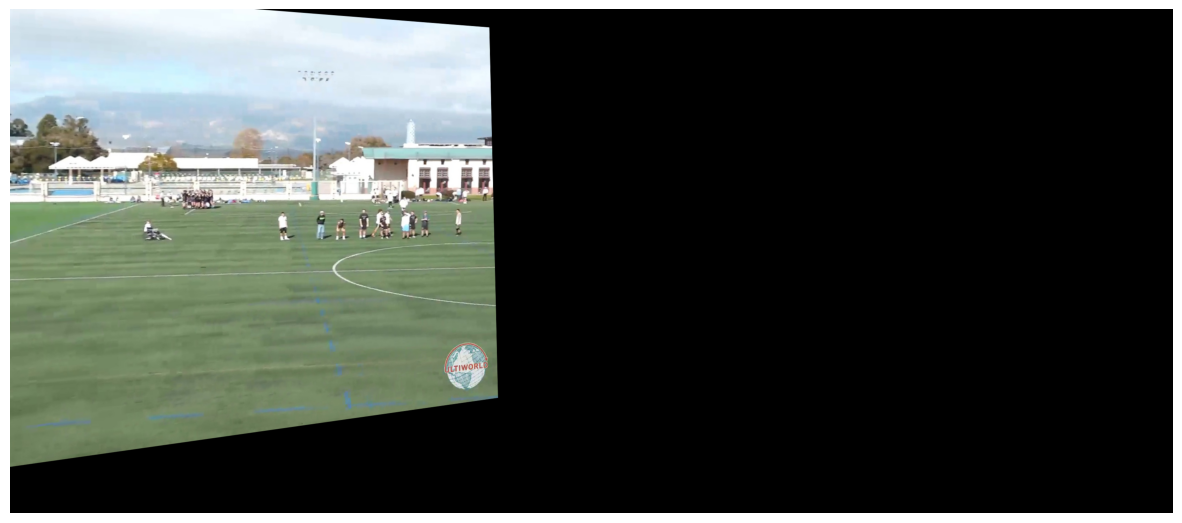

In [55]:
H = auto_homography(im1, im2, compute_homography)
projectedSource1 = cv.warpPerspective(im1, H, (proj_w, proj_h))
projectedSource1 = cv.cvtColor(projectedSource1, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15,40))
plt.imshow(projectedSource1)
plt.axis('off')

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

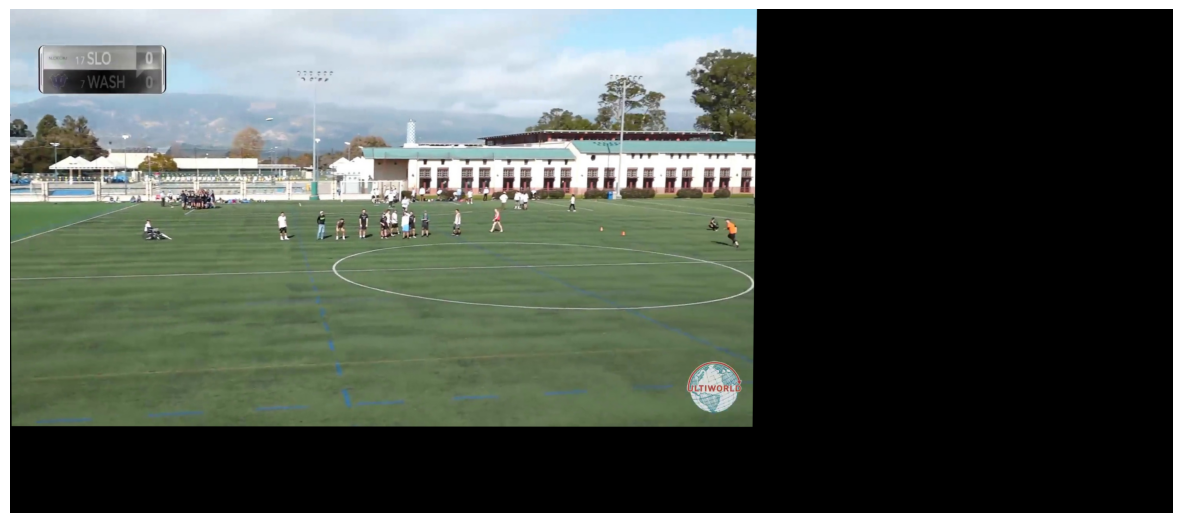

In [56]:
# Now make the next comparison
H = auto_homography(im2, projectedSource1, compute_homography)
projectedSource2 = cv.warpPerspective(im2, H, (proj_w, proj_h))
projectedSource2 = cv.cvtColor(projectedSource2, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15,40))
plt.imshow(projectedSource2)
plt.axis('off')

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

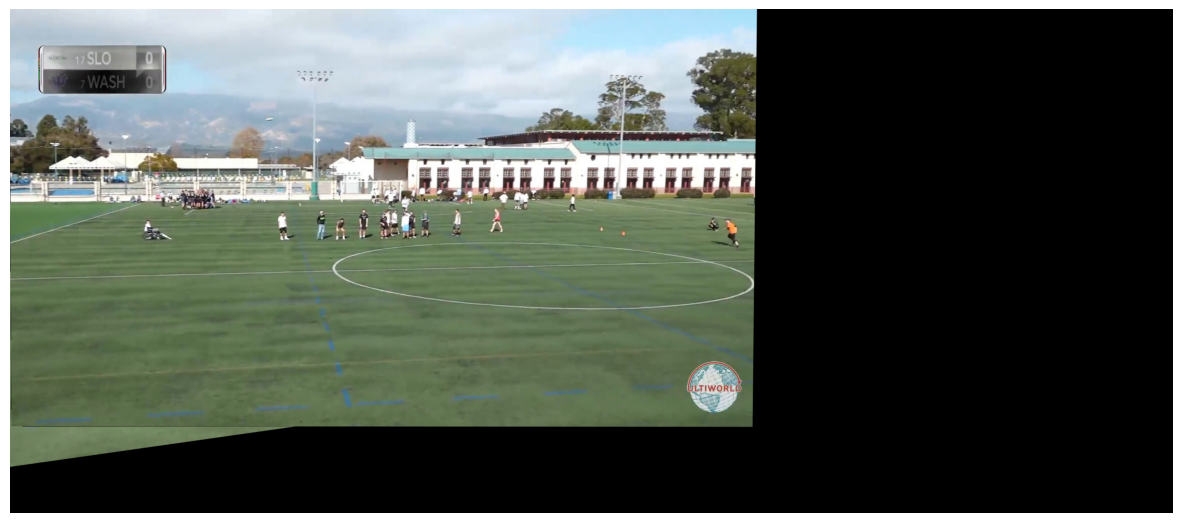

In [57]:
# and blend
blended = blendImages(projectedSource1, projectedSource2)
plt.figure(figsize=(15,40))
plt.imshow(blended)
plt.axis('off')

Things are looking good so far!

Let's continue this pattern for the next clip and see how things go from there

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

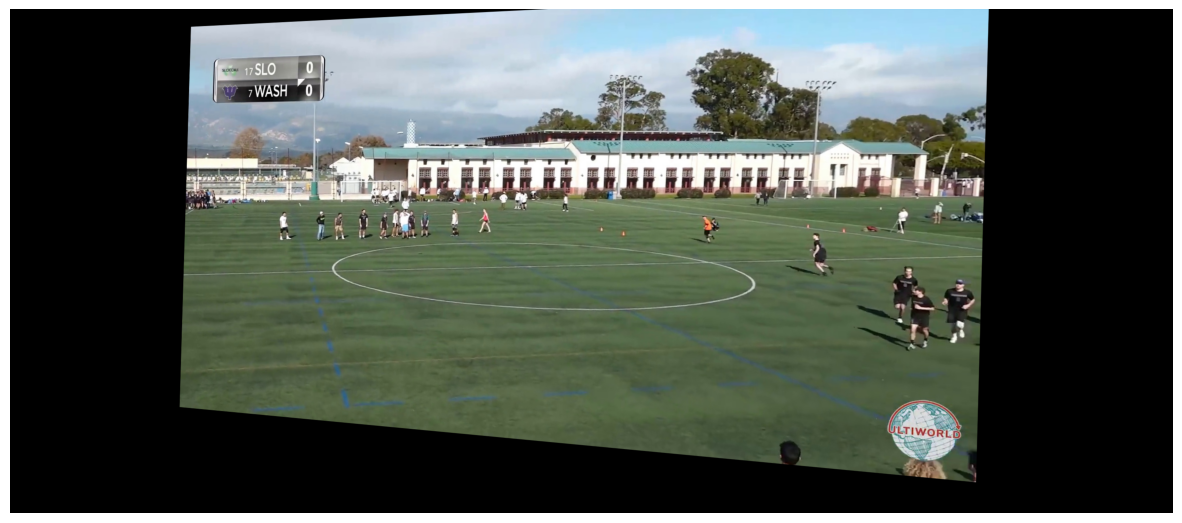

In [58]:
im3 = cv.imread('./images/input/clip-480.jpg')
H = auto_homography(im3, blended, compute_homography)
projectedSource3 = cv.warpPerspective(im3, H, (proj_w, proj_h))
projectedSource3 = cv.cvtColor(projectedSource3, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15,40))
plt.imshow(projectedSource3)
plt.axis('off')

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

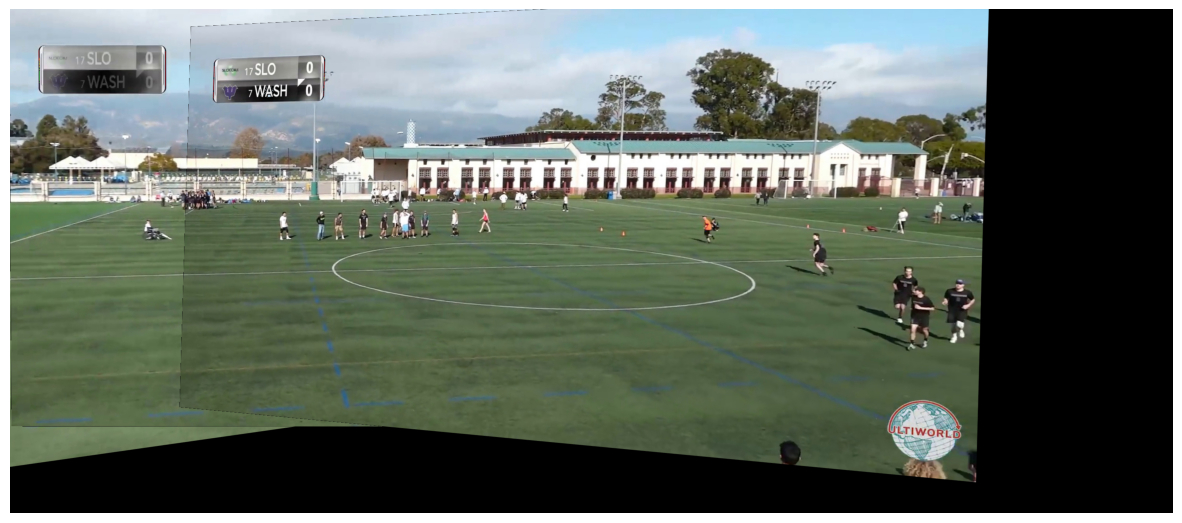

In [59]:
# and blend
blended = blendImages(blended, projectedSource3)
plt.figure(figsize=(15,40))
plt.imshow(blended)
plt.axis('off')

Looks like the projection and blending is going well as long as we carry forward the right parts of the images!

Let's try looping over the video to produce the projection

In [6]:
video = cv.VideoCapture('./vid/pull_SBI_2020.mp4')

ok, prev_frame = video.read()
if not ok:
    print('Cannot read video file')
    sys.exit()

ok, next_frame = video.read()

In [ ]:
H = auto_homography(prev_frame, next_frame, compute_homography)
projSource = cv.warpPerspective(prev_frame, H, (proj_w, proj_h))

The above code cell took over 40 seconds to complete. That doesn't bode well for the speed of this application. I'll have to look at compressing the frames before sending to homographication, or improve the performance of the homography functions.

In [8]:
H = auto_homography(next_frame, projSource, compute_homography)
projReference = cv.warpPerspective(next_frame, H, (proj_w, proj_h))

(np.float64(-0.5), np.float64(2999.5), np.float64(1299.5), np.float64(-0.5))

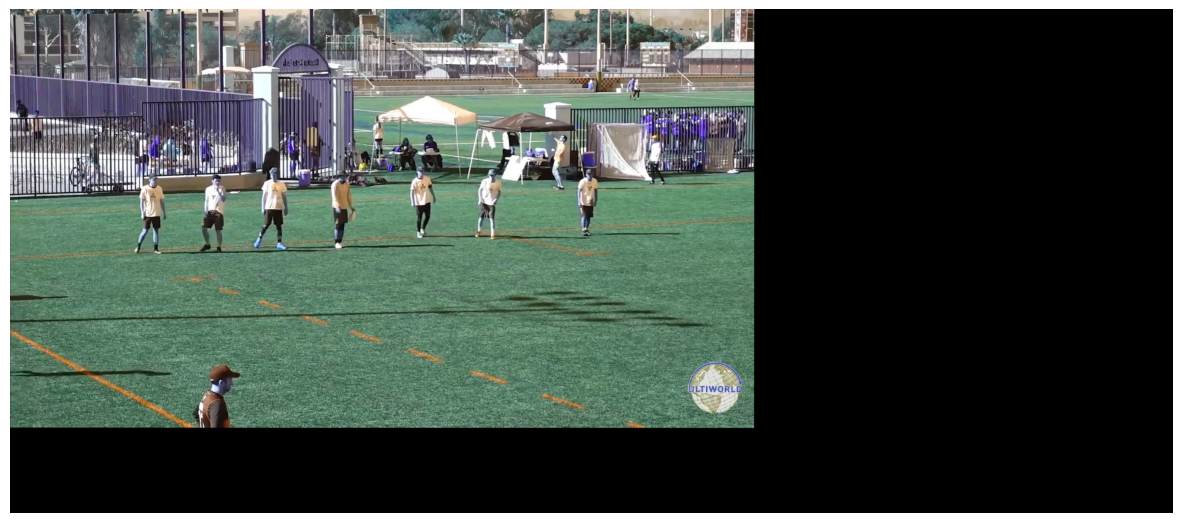

In [9]:
blend = blendImages(projSource, projReference)

plt.figure(figsize=(15,40))
plt.imshow(blend)
plt.axis('off')

In [ ]:
frame_i = 0

while True:
    ok, next_frame = video.read()
    if not ok:
        break

    if frame_i % 30 == 0: # down sampling the video frames
        H = auto_homography(next_frame, blend, compute_homography)

        projSource = cv.warpPerspective(next_frame, H, (proj_w, proj_h))
        projSource = cv.cvtColor(projSource, cv.COLOR_BGR2RGB)

        blend = blendImages(projSource, blend)

        # show the output frame
        # cv.imshow("Blended Frames", blend)

    frame_i += 1

    # key = cv.waitKey(1) & 0xFF
    # if key == ord("q"):
    #     break

In [ ]:
plt.figure(figsize=(15,40))
plt.imshow(blend)
plt.axis('off')

In [ ]:

# cleanup
video.release()
cv.destroyAllWindows()

NameError: name 'cv' is not defined